# Variational autoencoders
This is a continuation of the notes from [Francois Chollet's blog on autoencoders](https://blog.keras.io/building-autoencoders-in-keras.html).

# Introduction
VAEs are a slightly more modern and interesting take on autoencoders. Constraints are placed on the encoded representations being learned. More precisely, it is an autoencoder that **learns a latent variable model** for its input data. i.e., instead of letting your network learn an arbitrary function, your network learns the parameters of a probability distribution modeling your data. By sampling from this distribution, you can generate new input data samples, making VAEs **generative models**.

What about autoencoders? Why aren't they generative models? In short, it is difficult to ensure that the encoder will organize the latent space in a smart way that enables us to generate new data like GANs. The high degree of freedom in autoencoders leads to high overfitting, implying that some points in the latent space will give rise to meaningless content once decoded.

VAEs addresses this problem, by essentially regularizing the latent space. During training, autoencoders encode inputs to a single point. VAEs, on the other hand, map inputs to a distribution over the latent space.

<img src="https://miro.medium.com/max/2400/1*ejNnusxYrn1NRDZf4Kg2lw@2x.png" width=700/>

Image taken from a [blog](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) by Joseph and Baptiste Rocca that explains the concept of VAEs in more detail.


## General Idea (Kingma et al., ICLR 2014)
1. The encoder turns in the  input samples `x` into two parameters in a latent space: `z_mean` and `z_log_sigma`. 
2. We randomly sample similar points `z` from the latent normal distribution that is assumed to generate the data, via
```
z = z_mean + exp(z_log_sigma) * epsilon
```
where epsilon is a random normal tensor. This step might seem a bit weird for those of you who cares about math, because we applied a reparameterization trick (Kingma et al., 2014) in order to make sure back propagation can flow through the bottle neck node.
3. The decoder network maps these latent space points back to the original input data

In this notebook, we'll be once again working with the MNIST dataset


In [1]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np

# The VAE
<img src="VAE.jpg" width=700/>


First, the encoder

In [2]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2 # number of latent dimension. If latent_dim = 2, we can visualize in 2D coordinate

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
h = layers.Dense(intermediate_dim, activation='relu')(h)
h = layers.Dense(intermediate_dim, activation='relu')(h)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)


Use z_mean and z_log_sigmal to sample new similar points from the latent space

In [3]:
from keras import backend as K

# build a sampling layer
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

Map these sampled latent points back to reconstructed inputs:

In [4]:
# Create encoder, returns z_mean, z_log_sigma, and z
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
x = layers.Dense(intermediate_dim, activation='relu')(x)
x = layers.Dense(intermediate_dim, activation='relu')(x)

outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

What we've done so far allows us to instantiate 3 models:

* an end-to-end autoencoder mapping inputs to reconstructions
* an encoder mapping inputs to the latent space
* a generator that can take points on the latent space and will output the corresponding reconstructed samples.

We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

The LK divergence term makes sure that the latent space is close to a Gaussian normal distribution

In [5]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

We train our VAE on MNIST digits:

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 4s 2ms/step - loss: 207.8758 - val_loss: 162.3431
Epoch 2/100
1875/1875 [==============================] - 3s 2ms/step - loss: 159.2957 - val_loss: 152.4132
Epoch 3/100
1875/1875 [==============================] - 3s 2ms/step - loss: 151.3453 - val_loss: 149.3895
Epoch 4/100
1875/1875 [==============================] - 3s 2ms/step - loss: 148.5472 - val_loss: 147.7623
Epoch 5/100
1875/1875 [==============================] - 3s 2ms/step - loss: 146.7871 - val_loss: 146.6276
Epoch 6/100
1875/1875 [==============================] - 3s 2ms/step - loss: 145.5029 - val_loss: 145.1371
Epoch 7/100
1875/1875 [==============================] - 3s 2ms/step - loss: 144.6674 - val_loss: 143.6032
Epoch 8/100
1875/1875 [==============================] - 3s 2ms/step - loss: 142.9343 - val_loss: 142.1281
Epoch 9/100
1875/1875 [==============================] - 3s 2ms/step - loss: 142.1887 - val_loss: 141.6125
Epoch 10/100
1875/1875 [=============

Epoch 77/100
1875/1875 [==============================] - 3s 2ms/step - loss: 139.7776 - val_loss: 142.0248
Epoch 78/100
1875/1875 [==============================] - 3s 2ms/step - loss: 142.1143 - val_loss: 141.7853
Epoch 79/100
1875/1875 [==============================] - 3s 2ms/step - loss: 141.4212 - val_loss: 143.8165
Epoch 80/100
1875/1875 [==============================] - 3s 2ms/step - loss: 144.4698 - val_loss: 143.6938
Epoch 81/100
1875/1875 [==============================] - 3s 2ms/step - loss: 142.2042 - val_loss: 141.0659
Epoch 82/100
1875/1875 [==============================] - 3s 2ms/step - loss: 140.6078 - val_loss: 140.2432
Epoch 83/100
1875/1875 [==============================] - 3s 2ms/step - loss: 140.8494 - val_loss: 140.6892
Epoch 84/100
1875/1875 [==============================] - 3s 2ms/step - loss: 141.1494 - val_loss: 140.2752
Epoch 85/100
1875/1875 [==============================] - 3s 2ms/step - loss: 140.1783 - val_loss: 142.1026
Epoch 86/100
1875/1875 [====

Because our latent space is two-dimensional, there are a few cool visualizations that can be done at this point. One is to look at the neighborhoods of different classes on the latent 2D plane:

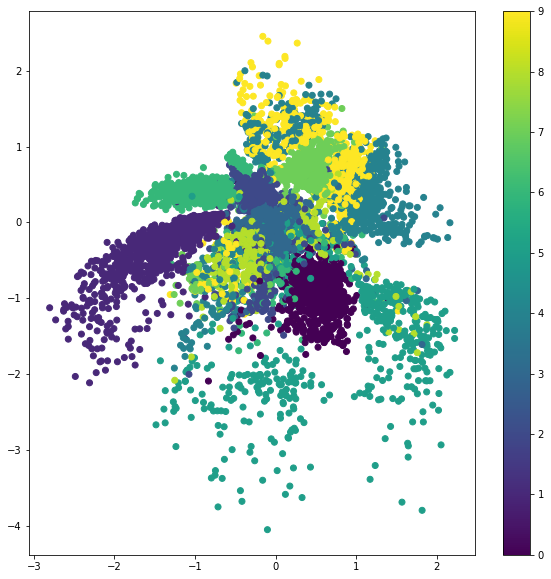

In [7]:
import matplotlib.pyplot as plt
batch_size=32
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
x_test_encoded = np.array(x_test_encoded)

# the encoder returns [mu,sigma,z], where z is sampled from the distribution mu and sigma
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[2,:,0], x_test_encoded[2,:,1], c=y_test)
plt.colorbar()
plt.show()

Each colored cluster represents a digit. Cool huh?

Because the VAE is a generative model, we can also use it to generate new digits! Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.

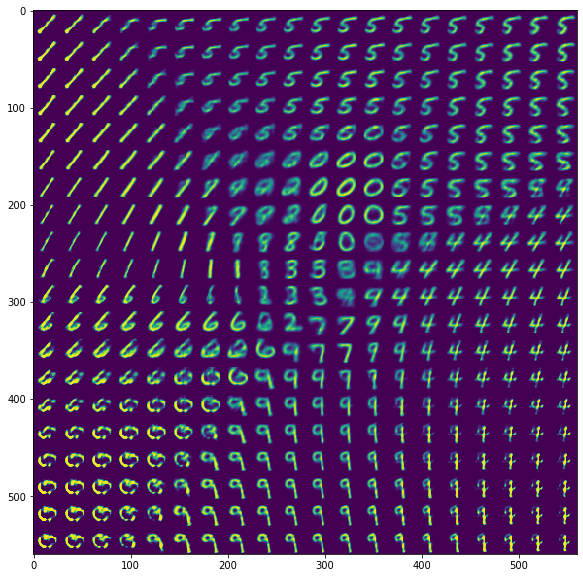

In [11]:
# Display a 2D manifold of the digits
n = 20  # figure with 15x15 digits
digit_size = 28
scale = 3 # if scale is too large, we'd be too many standard deviations from the norm, and we get gibberish
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

Its surprising to me how good our result is, even without using any conv layers

# Further reading
VAEs were first described by Kingma and Welling ([Auto-Encoding Variational Bayes, ICLR 2014](https://arxiv.org/pdf/1312.6114.pdf)). They showed neat examples on the MNIST dataset as well as the Frey Face dataset. I encourage interested readers to check out those examples.

If you have trouble getting good results, others have written in depth about MNIST generation using VAEs, which might be of help:
* https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/
* https://keras.io/examples/generative/vae/

VAEs have spawned a range of interesting projects, which may be of interest:
* Generating faces of lego figures ([link](https://www.echevarria.io/blog/lego-face-vae/))
* DeepMind combined LSTMs with VAEs to built the DRAW network ([link](https://deepmind.com/research/publications/draw-recurrent-neural-network-image-generation))
* VAE based language models (just do a quick google search)